# I. Imports 

In [32]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, RobustScaler, StandardScaler, FunctionTransformer, LabelEncoder, OneHotEncoder, Binarizer, OrdinalEncoder, Binarizer, MaxAbsScaler, PowerTransformer, SplineTransformer, QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from catboost import CatBoostRegressor
import seaborn as sns 

import os 
import warnings
warnings.filterwarnings("ignore")

# I.Data exploration:

In [7]:
training_data = pd.read_csv("train.csv")
training_data

,age,sex,bmi,children,smoker,region,charges
0,60,female,27.550,0,no,northeast,13217.09450
1,46,female,28.050,1,no,southeast,8233.09750
2,50,female,23.540,2,no,southeast,10107.22060
3,52,male,27.360,0,yes,northwest,24393.62240
4,54,male,32.775,0,no,northeast,10435.06525
...,...,...,...,...,...,...,...
931,57,male,42.130,1,yes,southeast,48675.51770
932,57,male,40.370,0,no,southeast,10982.50130
933,34,female,19.000,3,no,northeast,6753.03800
934,40,male,25.080,0,no,southeast,5415.66120


In [8]:
training_data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

* EN: Conversion of sex and smoker category in number to exploit numerical values.
* FR: Conversion du sexe et de la catégorie des fumeurs afin d'exploiter des valeurs numériques.


In [9]:
training_data.sex = np.where(training_data.sex == 'female', 0 , 1) 
training_data.sex = training_data.sex.astype(int)

training_data.smoker = np.where(training_data.smoker == 'no', 0 , 1)  
training_data.smoker = training_data.smoker.astype(int)


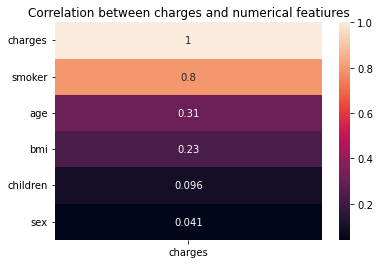

In [10]:
sns.heatmap(training_data.corr()[['charges']].sort_values('charges', ascending=False), annot=True)
plt.title('Correlation between charges and numerical featiures')
plt.show()

    * Smoking, age and BMI increase seem to be correlated. These appear to be the numerical factors that are most correlated with health care costs in this dataset. 
    
    * Les fumeurs, l'age et l'augmentation de l'IMC semblent bien correlés. Il semble que ce soit les facteurs numériques principalement corrélés aux frais de santé dans ce dataset. 

In [11]:
training_data.groupby(['bmi','age']).mean().sort_values('charges', ascending=False).head(15)

,,sex,children,smoker,charges
bmi,age,,,,
47.410,54,0.0,0.0,1.0,63770.42801
30.360,45,1.0,0.0,1.0,62592.87309
34.485,52,1.0,3.0,1.0,60021.39897
38.095,31,0.0,1.0,1.0,58571.07448
35.530,33,0.0,0.0,1.0,55135.40209
32.800,60,1.0,0.0,1.0,52590.82939
36.400,28,1.0,1.0,1.0,51194.55914
36.960,64,1.0,2.0,1.0,49577.66240
41.140,59,1.0,1.0,1.0,48970.24760


In [12]:
training_data.groupby(['age','smoker']).mean().sort_values('charges', ascending=False).head(15)

,,sex,bmi,children,charges
age,smoker,,,,
45,1,1.000000,30.360000,0.000000,62592.873090
54,1,0.500000,43.987500,1.500000,56159.803180
60,1,1.000000,37.873333,0.000000,49812.583063
58,1,1.000000,36.955000,2.000000,47496.494450
55,1,0.000000,35.200000,0.000000,44423.803000
28,1,1.000000,34.040000,0.500000,42933.353170
46,1,0.666667,35.815000,2.333333,42844.425850
59,1,0.333333,33.853333,0.666667,40848.605800
62,1,0.666667,29.726667,1.000000,40079.032067


* Almost all higher charges are associated with smoker and age.
* La pluspart des charges élevés sont associés à des fumeurs et des tranches d'age plutot élevés. 

In [24]:
training_data.smoker.value_counts()

0    750
1    186
Name: smoker, dtype: int64

In [25]:
# region:

In [7]:
training_data.groupby('region').mean().sort_values('charges', ascending=False)

,age,sex,bmi,children,smoker,charges
region,,,,,,
southeast,39.518519,0.514815,33.450593,1.037037,0.259259,15110.923096
northeast,39.328889,0.524444,29.192867,1.102222,0.182222,12872.527913
southwest,39.411765,0.497738,30.640271,1.090498,0.167421,12380.233857
northwest,38.681818,0.486364,29.158955,1.113636,0.172727,12226.485868


 * EN: The age groups are balanced well enough between regions. (Little more BMI and smokers in the southeast in this dataset) 
 * FR: Les tranches d'ages sont assez bien équilibrés entre les régions. (L'IMC et les fumeurs sont un peu plus élevé dans le sud-est dans ce jeu de donnée)

In [27]:
# Age:
training_data.groupby('age').mean().sort_values('charges', ascending=False).head(10)

,sex,bmi,children,smoker,charges
age,,,,,
64,0.578947,32.544737,0.789474,0.368421,24567.222667
61,0.500000,32.638333,0.666667,0.333333,23615.435738
63,0.461538,34.199615,0.692308,0.307692,21765.160619
60,0.529412,30.262941,0.117647,0.176471,21321.529325
62,0.357143,32.417143,0.571429,0.214286,20636.747090
44,0.500000,30.701944,1.277778,0.333333,19931.520747
43,0.545455,30.714091,1.681818,0.409091,19276.002388
59,0.454545,30.712500,1.090909,0.136364,18903.539570
52,0.588235,31.660588,1.117647,0.176471,18033.162711


In [26]:
training_data.describe()

,age,sex,bmi,children,smoker,charges
count,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000
mean,39.251068,0.506410,30.754834,1.083333,0.198718,13250.135245
std,14.000153,0.500226,6.262544,1.204048,0.399249,12422.018284
min,18.000000,0.000000,16.815000,0.000000,0.000000,1121.873900
25%,26.750000,0.000000,26.125000,0.000000,0.000000,4639.589225
50%,39.000000,1.000000,30.332500,1.000000,0.000000,9265.987900
75%,51.000000,1.000000,34.915000,2.000000,0.000000,16162.283287
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010


# II. Set of train and test data 

In [28]:
X = training_data.drop(columns=['charges'])
y = training_data['charges'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=2)

In [29]:
X_train.shape, X_test.shape

((795, 6), (141, 6))

In [30]:
# First training without data augmentation:
model_catboost = CatBoostRegressor(verbose=False)
model_catboost.fit(X_train.drop('region', axis=1), y_train)
model_catboost.score(X_test.drop('region', axis=1), y_test)

0.7518654494718838

# III. Data Augmentation

A. 

* Column instanciation associated to the risk related to the age
* Instanciation d'une colonne associé au risque liée à l'age:

In [ ]:
training_data['risk_age'] = 0
training_data['risk_age'][(training_data.age < 43) ] += 1
training_data['risk_age'][(training_data.age >= 43) & (training_data.age < 60) ] += 2
training_data['risk_age'][(training_data.age >= 60) ] += 3

B.
* Column instanciation of the risk related to age and the smoker status:
* Instanciation d'une colonne du risque liée à l'age et du statut de fumeur:

In [13]:
training_data['risk_age_smoker'] = 0
training_data['risk_age_smoker'][(training_data.smoker == 1)] += 1 

training_data['risk_age_smoker'][(training_data.smoker == 1) & (training_data.age < 43)] += 79
training_data['risk_age_smoker'][(training_data.smoker == 1) & (training_data.age >= 43) & (training_data.age < 60)] += 100
training_data['risk_age_smoker'][(training_data.smoker == 1) & (training_data.age >= 60)] += 181

C.
* Column instanciation of the risk of increased medical charges related to BMI 
* Instanciation d'une colonne pour le risque d'augmentation des frais de santé liée à l'IMC

* The WHO (World Health Organisation) establishes BMI standards as follows:
    - ~19-25: Normal 
    - 25-30: Overweight
    - 30-35: Obesity class 1 
    - 35-40; Obesity class 2
    - 40+: Obesity class 
    
* So, first i tried to create a column link to this standards.

In [31]:
training_data['risk_bmi'] = 0
training_data['risk_bmi'][(training_data.bmi > 25) & (training_data.bmi < 30)] += 4
training_data['risk_bmi'][(training_data.bmi > 30) & (training_data.bmi < 35)] += 4
training_data['risk_bmi'][(training_data.bmi > 35) & (training_data.bmi < 40)] += 4
training_data['risk_bmi'][(training_data.bmi >= 40)] += 8

D.
* Column instanciation of the risk of increased medical charges related to BMI and age
* Instanciation d'une colonne pour le risque d'augmentation des frais de santé liée à l'age et à l'IMC

In [15]:
training_data['risk_age_bmi'] = 0
training_data['risk_age_bmi'][(training_data.age < 43) & (training_data.bmi > 25) & (training_data.bmi <= 30)] += 2

training_data['risk_age_bmi'][(training_data.bmi > 30) & (training_data.bmi < 35) & (training_data.age < 43)] += 5
training_data['risk_age_bmi'][(training_data.bmi > 30) & (training_data.bmi < 35) & (training_data.age >= 43) & (training_data.age < 60)] += 9
training_data['risk_age_bmi'][(training_data.bmi > 30) & (training_data.bmi < 35) & (training_data.age >= 60)] += 14

training_data['risk_age_bmi'][ (training_data.bmi >= 35) & (training_data.bmi < 41) & (training_data.age < 43)] += 17
training_data['risk_age_bmi'][ (training_data.bmi >= 35) & (training_data.bmi < 41) & (training_data.age >= 43) & (training_data.age < 60)] += 21
training_data['risk_age_bmi'][ (training_data.bmi >= 35) & (training_data.bmi < 41) & (training_data.age >= 60)] += 52

training_data['risk_age_bmi'][(training_data.bmi >= 41) & (training_data.age < 43)] += 60
training_data['risk_age_bmi'][(training_data.bmi >= 41) & (training_data.age >= 43) & (training_data.age < 60)] += 90
training_data['risk_age_bmi'][(training_data.bmi >= 41) & (training_data.age >= 60)] += 120

* Visualisation of charges corelation in this dataset after data augmentation:
* Visualiastion de la corrélation aux frais de santé dans ce dataset après l'augmentation des données:

<AxesSubplot:>

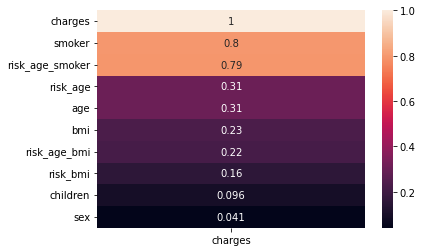

In [17]:
sns.heatmap(training_data.corr()[['charges']].sort_values('charges', ascending=False), annot=True)

    * Train and test split:
    * Séparation du jeu de test et d'entrainement:

In [18]:
X = training_data.drop(columns=['charges'])
y = training_data['charges'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=2)

model_catboost = CatBoostRegressor(verbose=False)
model_catboost.fit(X_train.drop('region', axis=1), y_train)
model_catboost.score(X_test.drop('region', axis=1), y_test)

0.8424126538707135

# V. Resume and setting pipeline and hyperparameters.

In [19]:
# Final preprocessing and setting hyperparameters and features selection until the score is better
# Cross-referencing between different features based on some knowledge about health risk factors and based on the best r2_score I could find.  

def proces(df):
    df.sex = np.where(df.sex == 'female', 0 , 1) 
    df.sex = df.sex.astype(int)

    df.smoker = np.where(df.smoker == 'no', 0 , 1)  
    df.smoker = df.smoker.astype(int)
    
    df.children = np.where(df.children > 0 , 1 , 0)  
    df.children = df.children.astype(int)
    
    df['risk_bmi'] = 0
    df['risk_bmi'][(df.bmi > 27) & (df.bmi < 32)] += 4
    df['risk_bmi'][(df.bmi >= 32)] += 8
    
    df['risk_age'] = 0
    df['risk_age'][(df.age < 43) ] += 1
    df['risk_age'][(df.age >= 43) & (df.age < 60) ] += 2
    df['risk_age'][(df.age >= 60) ] += 3

    
    # This classification finalely works better than WHO organisation classification. 
    df['risk_age_bmi'] = 0
    df['risk_age_bmi'][(df.age < 43) & (df.bmi > 25) & (df.bmi <= 30)] += 2
    
    df['risk_age_bmi'][(df.bmi > 30) & (df.bmi < 35) & (df.age < 43)] += 5
    df['risk_age_bmi'][(df.bmi > 30) & (df.bmi < 35) & (df.age >= 43) & (df.age < 60)] += 9
    df['risk_age_bmi'][(df.bmi > 30) & (df.bmi < 35) & (df.age >= 60)] += 14
    
    df['risk_age_bmi'][ (df.bmi >= 35) & (df.bmi < 41) & (df.age < 43)] += 17
    df['risk_age_bmi'][ (df.bmi >= 35) & (df.bmi < 41) & (df.age >= 43) & (df.age < 60)] += 21
    df['risk_age_bmi'][ (df.bmi >= 35) & (df.bmi < 41) & (df.age >= 60)] += 52
    
    df['risk_age_bmi'][(df.bmi >= 41) & (df.age < 43)] += 60
    df['risk_age_bmi'][(df.bmi >= 41) & (df.age >= 43) & (df.age < 60)] += 90
    df['risk_age_bmi'][(df.bmi >= 41) & (df.age >= 60)] += 120
    
    
    df['risk_age_smoker'] = 0
    df['risk_age_smoker'][(df.smoker == 1)] += 1 
    
    df['risk_age_smoker'][(df.smoker == 1) & (df.age < 43)] += 79
    df['risk_age_smoker'][(df.smoker == 1) & (df.age >= 43) & (df.age < 60)] += 100
    df['risk_age_smoker'][(df.smoker == 1) & (df.age >= 60)] += 181
    
    df['man_condition'] = 0
    df.man_condition[(df.sex == 1) & (df.children == 0)] += 1
    
    df['total_risk'] = 0 
    df['total_risk'] = df.risk_bmi + df.risk_age_bmi + df.risk_age_smoker + df.man_condition
    
    return df


# Setting of train and test data 
training_data = pd.read_csv("train.csv")
training_data = proces(training_data)

X = training_data.drop(columns=['charges'])
y = training_data['charges'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=2)



# Features selection:
features_1 = ['age','smoker','risk_age_bmi','risk_age_smoker','man_condition','risk_age']
features_2 = ['region','children','risk_age_bmi','smoker']
features_3 = ['bmi','age','risk_age_bmi','risk_age_smoker','man_condition']
features_4 = ['risk_age_bmi','region','risk_age_smoker','risk_bmi']


# I also tried to Binarize total_risk column with good threshold but finallely it wasnt conclusive.
# total_column = ['total_risk']
# total_pipeline = make_pipeline(Binarizer(threshold=51))
# (total_pipeline, total_column)


# Pipelines functions 
logfunc = FunctionTransformer(func=np.log1p)
pipeline_1 = make_pipeline( logfunc, MinMaxScaler(), PolynomialFeatures())
pipeline_2 = make_pipeline(OneHotEncoder())
pipeline_3 = make_pipeline(logfunc, MinMaxScaler(), PolynomialFeatures())
pipeline_4 = make_pipeline(OrdinalEncoder())

preprocessor = make_column_transformer((pipeline_1, features_1),(pipeline_2 , features_2), (pipeline_3 , features_3), (pipeline_4, features_4)) # (total_pipeline, total_column)

model = make_pipeline(preprocessor, CatBoostRegressor(learning_rate = 0.05555549, depth=3, iterations=1920, random_seed=2, verbose=False, l2_leaf_reg=44 ))
model.fit(X_train,y_train)
model.score(X_test, y_test)

0.8591576582209983

# More evaluation: 

In [23]:
training_data['prediction'] = model.predict(training_data)
training_data['diff'] = np.abs(training_data.charges - training_data.prediction)
training_data.groupby('bmi').mean().sort_values('diff', ascending=False).head(30)

,age,sex,children,smoker,charges,risk_bmi,risk_age,risk_age_bmi,risk_age_smoker,man_condition,total_risk,prediction,diff
bmi,,,,,,,,,,,,,
41.420,40.000000,0.000000,1.000000,0.0,28476.734990,8.0,1.000000,60.000000,0.0,0.000000,68.000000,10746.286374,17730.448616
26.070,42.000000,1.000000,1.000000,1.0,38245.593270,0.0,1.000000,2.000000,80.0,0.000000,82.000000,21962.130131,16283.463139
37.525,52.000000,0.000000,1.000000,0.0,33471.971890,8.0,2.000000,21.000000,0.0,0.000000,29.000000,18033.182688,15438.789202
31.020,21.000000,1.000000,0.000000,0.0,16586.497710,4.0,1.000000,5.000000,0.0,1.000000,10.000000,3267.810208,13318.687502
37.715,55.000000,1.000000,1.000000,0.0,30063.580550,8.0,2.000000,21.000000,0.0,0.000000,29.000000,16831.995234,13231.585316
18.715,23.000000,1.000000,0.000000,0.0,21595.382290,0.0,1.000000,0.000000,0.0,1.000000,1.000000,8916.159289,12679.223001
30.360,45.000000,1.000000,0.000000,1.0,62592.873090,4.0,2.000000,9.000000,101.0,1.000000,115.000000,51271.437127,11321.435963
36.520,59.000000,0.000000,1.000000,0.0,28287.897660,8.0,2.000000,21.000000,0.0,0.000000,29.000000,17172.431925,11115.465735
38.280,18.000000,0.000000,0.000000,0.0,14133.037750,8.0,1.000000,17.000000,0.0,0.000000,25.000000,3425.254746,10707.783004


- Once score are good enough after adjusting, I use all the data to predict the test charges:

# VI. Full fit and submission of prediction:

In [24]:
# Train with full dataset and submit:
training_data = pd.read_csv("train.csv")
training_data = proces(training_data)
X_train = training_data.drop(columns=['charges'])
y_train = training_data['charges'].values


model = make_pipeline(preprocessor, CatBoostRegressor(learning_rate = 0.05555549, depth=3, iterations=1920, random_seed=2, verbose=False, l2_leaf_reg=44 ))
model.fit(X_train,y_train)

original_validation_data = pd.read_csv('test.csv', header=0)
validation_data = original_validation_data.set_index('trustii_id')
validation_data = proces(validation_data)

prediction = model.predict(validation_data)
validation_data['charges'] = prediction
validation_data.to_csv('risk_bmi_age_last2_new.csv', index=True, encoding='UTF-8')
validation_data

,age,sex,bmi,children,smoker,region,risk_bmi,risk_age,risk_age_bmi,risk_age_smoker,man_condition,total_risk,charges
trustii_id,,,,,,,,,,,,,
1,51,0,34.960,1,1,northeast,8,2,9,101,0,118,44531.849434
2,52,1,36.765,1,0,northwest,8,2,21,0,0,29,13916.378310
3,46,0,27.720,1,0,southeast,4,2,0,0,0,4,10281.807514
4,48,1,37.290,1,0,southeast,8,2,21,0,0,29,10764.049237
5,35,0,23.465,1,0,northeast,0,1,0,0,0,0,8044.469470
...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,27,1,31.130,1,1,southeast,4,1,5,80,0,89,36700.618467
399,52,0,30.875,0,0,northeast,4,2,9,0,0,13,11944.750625
400,52,1,32.775,1,0,northwest,8,2,9,0,0,17,12968.869555
